In [137]:
### Cargan las librerias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import seaborn as sns

In [13]:
## Cargan los datasets, tienen que ser las rutas locales, o pueden subirlas a un repositorio git y direccionar las rutas

csat_df = pd.read_excel("C:/Users/User/Desktop/Pruebas Tecnicas/IntouchCX/Datasets/csat_data.xlsx")
audit_df = pd.read_excel("C:/Users/User/Desktop/Pruebas Tecnicas/IntouchCX/Datasets/self_audit_data.xlsx")

In [19]:
## Ser revisan que las tablas hayan cargado
csat_df.head()

,week,response_date,contact_method,csat_count,sat_time,professionalism,knowledge,clarity,understand_needs,ability_solve,empathy,inquiry_resolved,inquiry_contact_count,topic_1_2_3,Tenure_Bucket,agent_name
0,2024-07-28,2024-07-31,Email,0,1,0,0,0,0,0,0,No,2-3 Times,Salon | Services Issue | Hair Service,Days 180+,Agent_2
1,2024-04-07,2024-04-10,Email,0,0,0,0,0,0,0,0,No,2-3 Times,Store | Guest Service Issues | Associate Issue,Days 180+,Agent_2
2,2024-04-28,2024-04-28,Email,0,0,0,0,0,0,0,0,No,First Contact,Store | Guest Service Issues | Associate Issue,Days 180+,Agent_2
3,2024-06-09,2024-06-09,Voice,0,0,0,0,0,0,0,1,No,2-3 Times,Store | Returns and Refunds | Return Policy Co...,Days 180+,Agent_2
4,2024-05-05,2024-05-05,Email,0,0,0,0,0,0,0,0,No,First Contact,Salon | Services Issue | Hair Service,Days 180+,Agent_2


In [17]:
## Ser revisan que las tablas hayan cargado
audit_df.head()

,date,agent_name,team_leader,home_channel,topic_1_2_3,professionalism,clarity,empathy,value_guest_time,ability_solve,opportunities,further_support,csat_count,self_csat
0,2024-03-30,Agent_1,Team_Leader_36,Voice,Website - Shipment Issue - Delivery Status,1,1,0,1,1,Empathy,Empathy,1,1
1,2024-03-30,Agent_2,Team_Leader_36,Store Team,Store - Guest Service Issues - Associate Issue,1,1,1,1,1,Resource Utilization,Customer Satisfaction,1,1
2,2024-03-29,Agent_3,Team_Leader_37,Voice,Website - Shipment Issue - Delivery Status,1,0,0,0,1,Effective Communication,Customer Satisfaction,0,1
3,2024-03-28,Agent_4,Team_Leader_37,Voice,Website - Shipment Issue - Stuck in Status,1,1,1,1,0,Professionalism,De-Escalation,0,0
4,2024-04-05,Agent_5,Team_Leader_36,Store Team,Salon - Services Issue - Facilities Issue,1,1,1,1,1,Effective Communication,Customer Satisfaction,1,1


In [21]:
csat_df.shape

(4395, 16)

In [31]:
csat_df.dtypes

week                     datetime64[ns]
response_date            datetime64[ns]
contact_method                   object
csat_count                        int64
sat_time                          int64
professionalism                   int64
knowledge                         int64
clarity                           int64
understand_needs                  int64
ability_solve                     int64
empathy                           int64
inquiry_resolved                 object
inquiry_contact_count            object
topic_1_2_3                      object
Tenure_Bucket                    object
agent_name                       object
dtype: object

In [33]:
audit_df.dtypes

date                datetime64[ns]
agent_name                  object
team_leader                 object
home_channel                object
topic_1_2_3                 object
professionalism              int64
clarity                      int64
empathy                      int64
value_guest_time             int64
ability_solve                int64
opportunities               object
further_support             object
csat_count                   int64
self_csat                    int64
dtype: object

In [25]:
audit_df.shape

(117, 14)

Overall CSAT before and after self-audit launch:
    post_audit      mean  count
0       False  0.697749    933
1        True  0.675043   3462


''

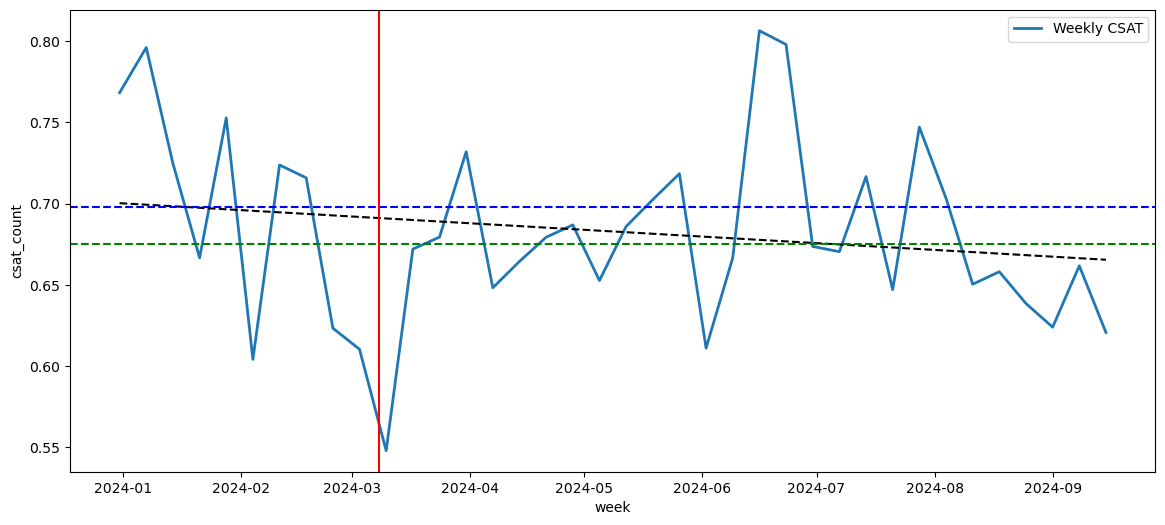

In [53]:
## 1)

## Cambio la satisfaccion del cliente despues de marzo, despues de la introduccion del self audit?

df_csat = csat_df.copy()

df_csat["post_audit"] = df_csat["response_date"] >= pd.Timestamp("2024-03-08") 

overall_csat = df_csat.groupby('post_audit')['csat_count'].agg(['mean', 'count']).reset_index()
print("Overall CSAT before and after self-audit launch:\n", overall_csat)

weekly = df_csat.groupby('week')['csat_count'].mean().reset_index()

pre_avg = df_csat[df_csat['post_audit'] == False]['csat_count'].mean()
post_avg = df_csat[df_csat['post_audit'] == True]['csat_count'].mean()

plt.figure(figsize=(14, 6))
sns.lineplot(data=weekly, x='week', y='csat_count', label='Weekly CSAT', linewidth=2)

z = np.polyfit(weekly['week'].map(pd.Timestamp.toordinal), weekly['csat_count'], 1)
p = np.poly1d(z)
plt.plot(weekly['week'], p(weekly['week'].map(pd.Timestamp.toordinal)), "k--", label='Trendline')
plt.axhline(pre_avg, color='blue', linestyle='--', label=f'Pre-Audit Avg: {pre_avg:.2f}')
plt.axhline(post_avg, color='green', linestyle='--', label=f'Post-Audit Avg: {post_avg:.2f}')

plt.axvline(pd.Timestamp('2024-03-08'), color='red', linestyle='-', label='Audit Launch (Mar 2024)')
;


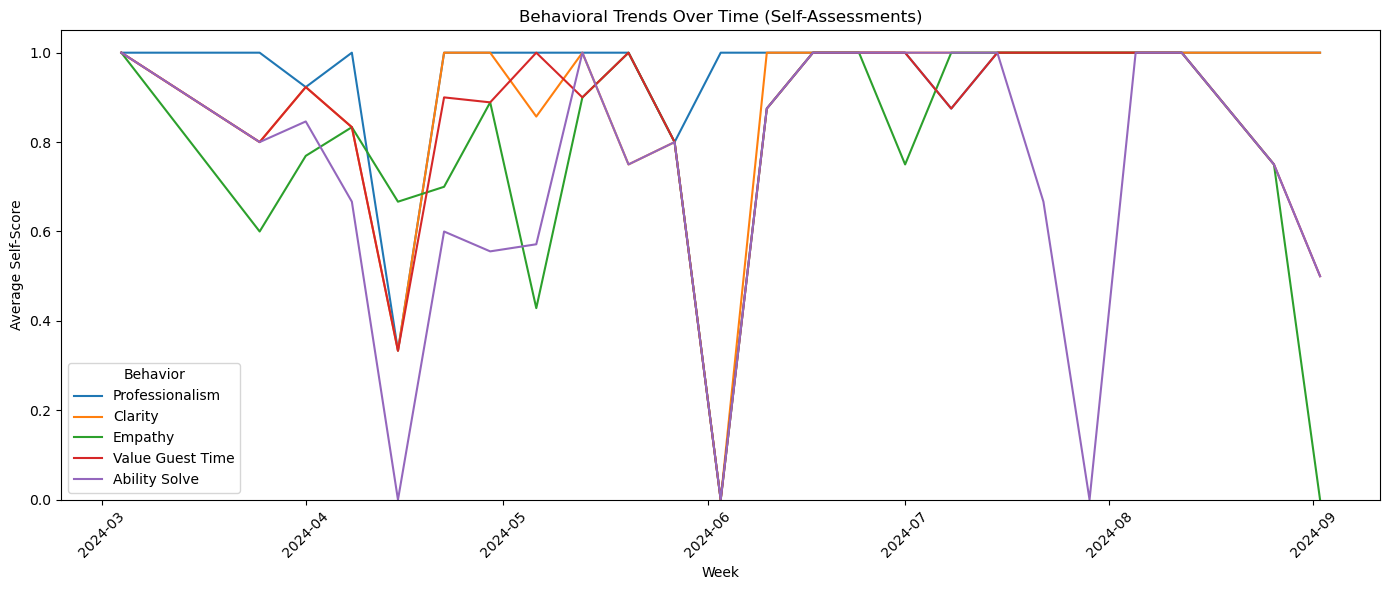

In [61]:
## 2)

### Han habido mejoras medibles en las metricas evaluadas en la autoevaluacion?

df_audit = audit_df.copy()

df_audit['week'] = df_audit['date'].dt.to_period('W').apply(lambda r: r.start_time)

behavior_cols = ['professionalism', 'clarity', 'empathy', 'value_guest_time', 'ability_solve']
weekly_behaviors = df_audit.groupby('week')[behavior_cols].mean().reset_index()

plt.figure(figsize=(14, 6))
for col in behavior_cols:
    sns.lineplot(data=weekly_behaviors, x='week', y=col, label=col.replace('_', ' ').title())

plt.title('Behavioral Trends Over Time (Self-Assessments)')
plt.xlabel('Week')
plt.ylabel('Average Self-Score')
plt.xticks(rotation=45)
plt.ylim(0, 1.05)
plt.legend(title='Behavior')
plt.tight_layout()
plt.show()


In [63]:
## 3)

### Analisis de Tenure contra las metricas, se analizo con cada categoria de Tenure original y se hizo ingenieria de variables para las especificadas en la definicion

guest_behavior_cols = [
    'professionalism', 'clarity', 'empathy', 
    'knowledge', 'ability_solve', 'understand_needs'
]

tenure_behavior = df_csat.groupby('Tenure_Bucket')[guest_behavior_cols].mean().reset_index()

tenure_behavior_melted = tenure_behavior.melt(id_vars='Tenure_Bucket', 
                                               var_name='Behavior', 
                                               value_name='Average_Score')


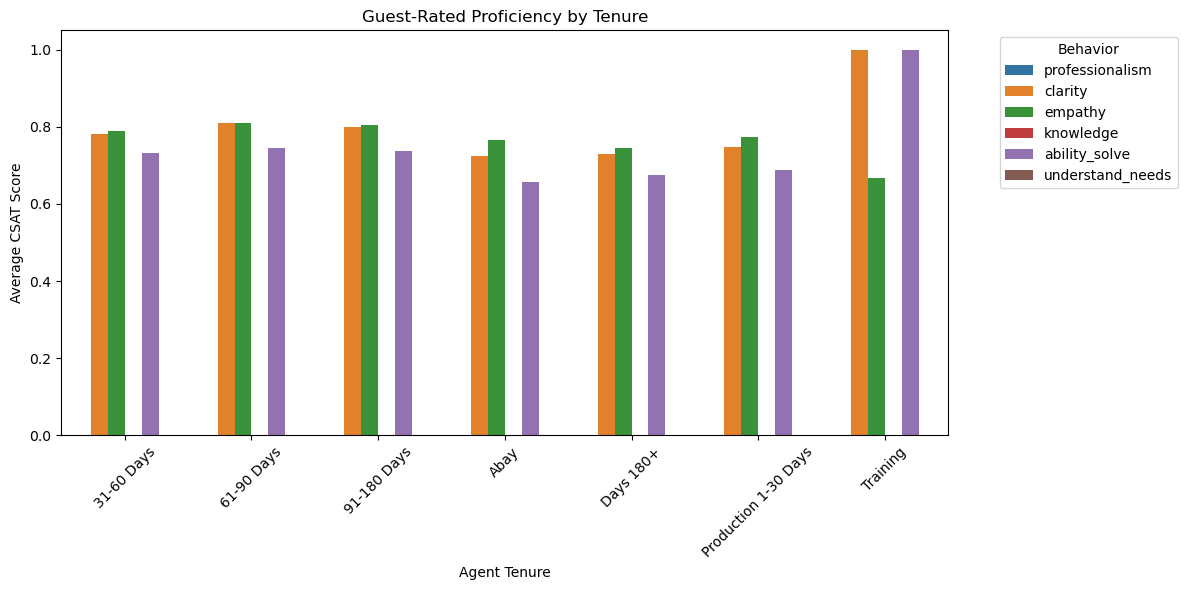

In [65]:
plt.figure(figsize=(12, 6))
sns.barplot(data=tenure_behavior_melted, x='Tenure_Bucket', y='Average_Score', hue='Behavior')
plt.title('Guest-Rated Proficiency by Tenure')
plt.ylabel('Average CSAT Score')
plt.xlabel('Agent Tenure')
plt.xticks(rotation=45)
plt.ylim(0, 1.05)
plt.legend(title='Behavior', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [69]:
## Union de tablas para comparar con auto auditoria

## Creo una tabla dimensional para cada tenure y cada agente y poder relacionarla con la tabla de hechos
tenure_lookup = df_csat[['agent_name', 'Tenure_Bucket']].drop_duplicates()

df_audit_metrics = pd.merge(df_audit, tenure_lookup, on='agent_name', how='left')

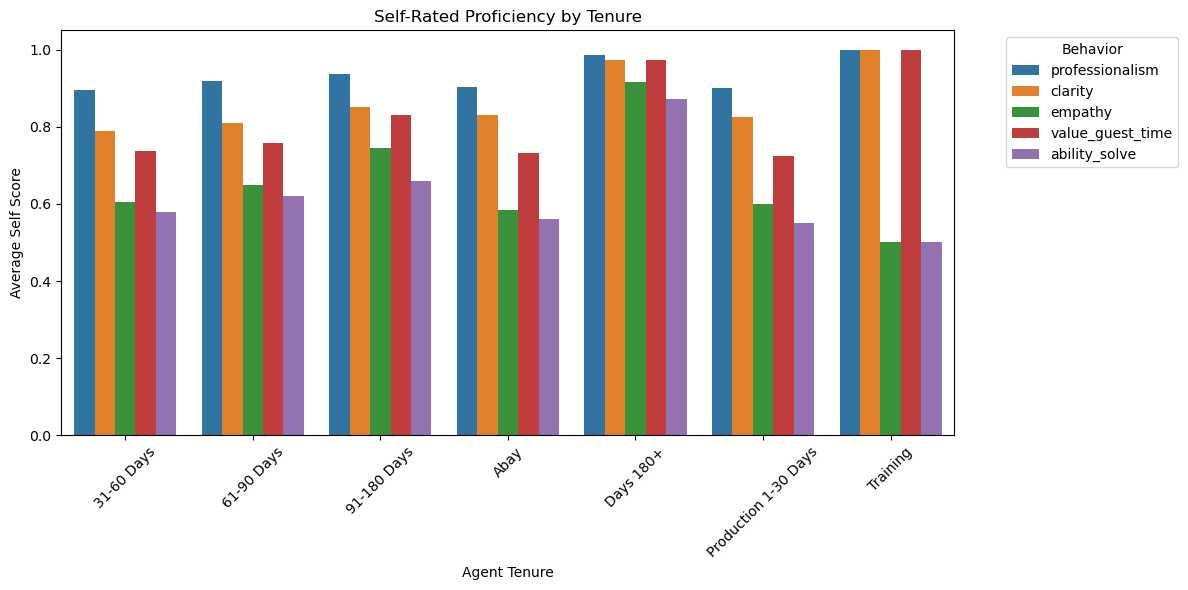

''

In [71]:
self_behavior_cols = [
    'professionalism', 'clarity', 'empathy',
    'value_guest_time', 'ability_solve'
]

tenure_self_behavior = df_audit_metrics.groupby('Tenure_Bucket')[self_behavior_cols].mean().reset_index()
tenure_self_metrics = tenure_self_behavior.melt(id_vars='Tenure_Bucket', 
                                                         var_name='Behavior', 
                                                         value_name='Average_Score')

plt.figure(figsize=(12, 6))
sns.barplot(data=tenure_self_metrics, x='Tenure_Bucket', y='Average_Score', hue='Behavior')
plt.title('Self-Rated Proficiency by Tenure')
plt.ylabel('Average Self Score')
plt.xlabel('Agent Tenure')
plt.xticks(rotation=45)
plt.ylim(0, 1.05)
plt.legend(title='Behavior', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
;

In [73]:
def map_tenure_stage(tenure):
    if tenure == 'Training':
        return 'Training (Week 1)'
    elif tenure == 'Abay':
        return 'Abay (Week 2)'
    else:
        return 'Production'

df_csat['tenure_stage'] = df_csat['Tenure_Bucket'].apply(map_tenure_stage)


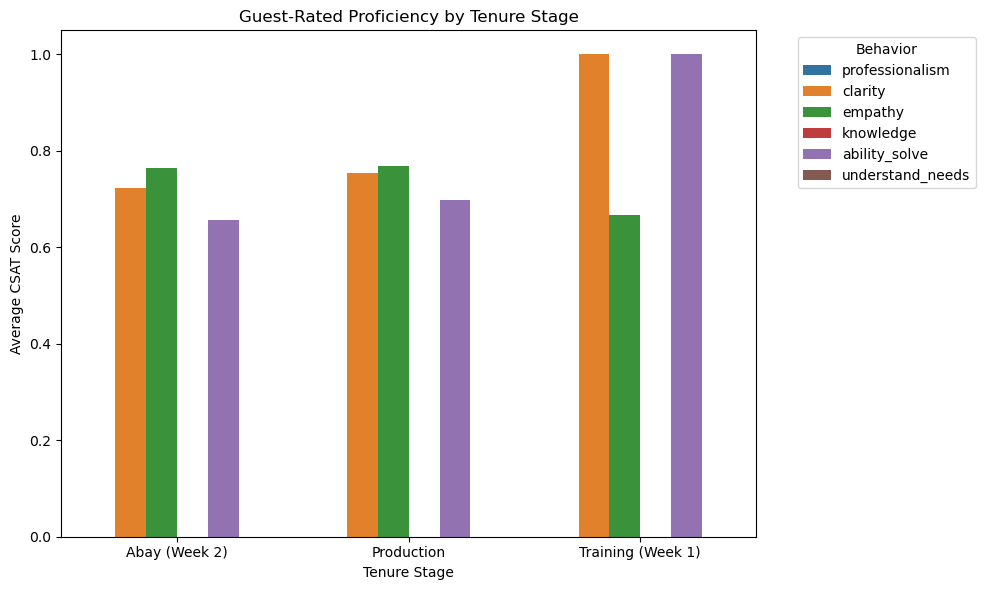

In [75]:

tenure_stage_behavior = df_csat.groupby('tenure_stage')[guest_behavior_cols].mean().reset_index()
tenure_stage_behavior_melted = tenure_stage_behavior.melt(
    id_vars='tenure_stage',
    var_name='Behavior',
    value_name='Average_Score'
)

plt.figure(figsize=(10, 6))
sns.barplot(data=tenure_stage_behavior_melted, x='tenure_stage', y='Average_Score', hue='Behavior')
plt.title('Guest-Rated Proficiency by Tenure Stage')
plt.ylabel('Average CSAT Score')
plt.xlabel('Tenure Stage')
plt.ylim(0, 1.05)
plt.legend(title='Behavior', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [97]:
## Hago join de las tablas para tener una sola tabla, con llave en las columnas de agente y fecha 

merged = pd.merge(df_audit, df_csat, left_on=['agent_name', 'date'], right_on=['agent_name', 'response_date'], how='inner')


## Defino las columnas a comparar
cols = {
    'professionalism_x': 'professionalism_y',
    'clarity_x': 'clarity_y',
    'empathy_x': 'empathy_y',
    'ability_solve_x': 'ability_solve_y',
    'value_guest_time': 'sat_time'  
}

# se itera la metrica para cada columna y se guarda en la variable result
result = []

for self_col, guest_col in cols.items():
    self_avg = merged[self_col].mean()
    guest_avg = merged[guest_col].mean()
    gap = self_avg - guest_avg
    result.append([self_col.replace('_x', ''), round(self_avg, 3), round(guest_avg, 3), round(gap, 3)])


## visualizacion de los resultados en una tabla
df_result = pd.DataFrame(result, columns=['Behavior', 'Self Avg', 'Guest Avg', 'Gap (Self - Guest)'])
print(df_result)


           Behavior  Self Avg  Guest Avg  Gap (Self - Guest)
0   professionalism     0.938      0.000               0.938
1           clarity     0.914      0.567               0.348
2           empathy     0.762      0.595               0.167
3     ability_solve     0.776      0.519               0.257
4  value_guest_time     0.843      0.533               0.310


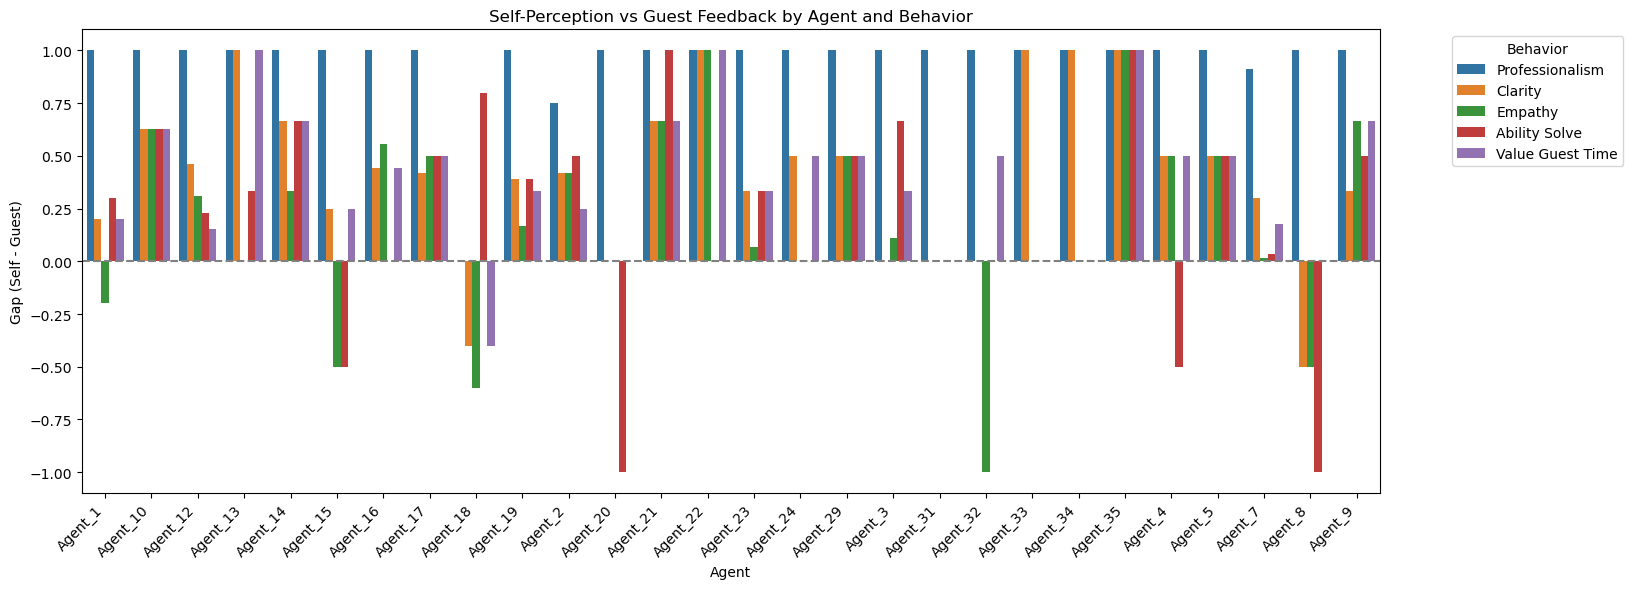

In [99]:

## Se agrupan las metricas por agente
agent_metrics = merged.groupby('agent_name')[
    ['professionalism_x', 'professionalism_y',
     'clarity_x', 'clarity_y',
     'empathy_x', 'empathy_y',
     'ability_solve_x', 'ability_solve_y',
     'value_guest_time', 'sat_time']
].mean().reset_index()


agent_metrics['gap_professionalism'] = agent_metrics['professionalism_x'] - agent_metrics['professionalism_y']
agent_metrics['gap_clarity'] = agent_metrics['clarity_x'] - agent_metrics['clarity_y']
agent_metrics['gap_empathy'] = agent_metrics['empathy_x'] - agent_metrics['empathy_y']
agent_metrics['gap_ability_solve'] = agent_metrics['ability_solve_x'] - agent_metrics['ability_solve_y']
agent_metrics['gap_value_guest_time'] = agent_metrics['value_guest_time'] - agent_metrics['sat_time']


melted = agent_metrics.melt(
    id_vars='agent_name',
    value_vars=[
        'gap_professionalism', 'gap_clarity', 'gap_empathy',
        'gap_ability_solve', 'gap_value_guest_time'
    ],
    var_name='Behavior',
    value_name='Gap'
)


melted['Behavior'] = melted['Behavior'].str.replace('gap_', '').str.replace('_', ' ').str.title()

### Grafico

plt.figure(figsize=(14, 6))
sns.barplot(data=melted, x='agent_name', y='Gap', hue='Behavior')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Self-Perception vs Guest Feedback by Agent and Behavior')
plt.ylabel('Gap (Self - Guest)')
plt.xlabel('Agent')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(title='Behavior', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [117]:
df_csat = csat_df.copy()

df_csat['inquiry_resolved'] = df_csat['inquiry_resolved'].apply(lambda x: 1 if str(x).strip().lower() == 'yes' else 0)



In [119]:
df_csat['inquiry_resolved']

0       0
1       0
2       0
3       0
4       0
       ..
4390    0
4391    1
4392    0
4393    1
4394    1
Name: inquiry_resolved, Length: 4395, dtype: int64

C:\Users\User\AppData\Local\Temp\ipykernel_9240\1091843611.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=unresolved_df, x='Unresolved Cases', y='Behavior', palette='Reds_r')


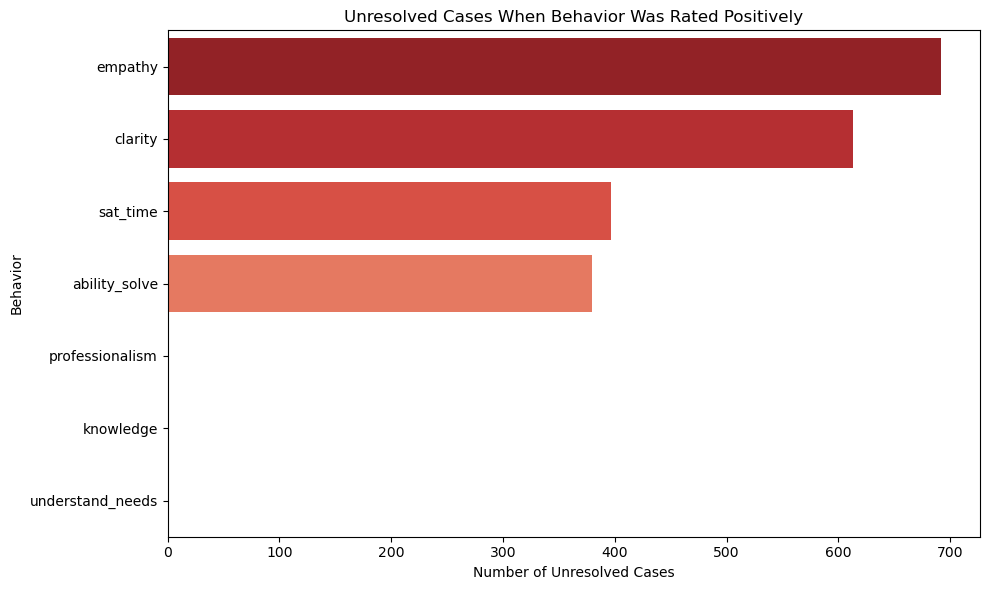

           Behavior  Unresolved Cases
6           empathy               692
3           clarity               613
1          sat_time               397
5     ability_solve               380
0   professionalism                 0
2         knowledge                 0
4  understand_needs                 0


In [123]:
behavior_cols = [
    'professionalism', 'sat_time', 'knowledge', 
    'clarity', 'understand_needs', 'ability_solve', 'empathy'
]


unresolved_counts = []

for col in behavior_cols:
    count = df_csat[(df_csat[col] == 1) & (df_csat['inquiry_resolved'] == 0)].shape[0]
    unresolved_counts.append((col, count))


unresolved_df = pd.DataFrame(unresolved_counts, columns=['Behavior', 'Unresolved Cases'])


unresolved_df = unresolved_df.sort_values(by='Unresolved Cases', ascending=False)


plt.figure(figsize=(10, 6))
sns.barplot(data=unresolved_df, x='Unresolved Cases', y='Behavior', palette='Reds_r')
plt.title('Unresolved Cases When Behavior Was Rated Positively')
plt.xlabel('Number of Unresolved Cases')
plt.ylabel('Behavior')
plt.tight_layout()
plt.show()

print(unresolved_df)

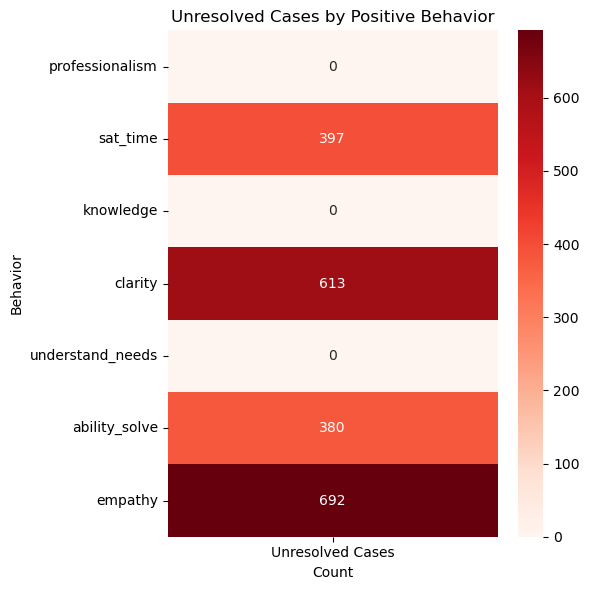

In [125]:



behavior_cols = [
    'professionalism', 'sat_time', 'knowledge', 
    'clarity', 'understand_needs', 'ability_solve', 'empathy'
]

unresolved_counts = []

for col in behavior_cols:
    count = df_csat[(df_csat[col] == 1) & (df_csat['inquiry_resolved'] == 0)].shape[0]
    unresolved_counts.append(count)

# Crear DataFrame para heatmap
heatmap_data = pd.DataFrame({'Unresolved Cases': unresolved_counts}, index=behavior_cols)

# Graficar heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(heatmap_data, annot=True, cmap='Reds', fmt='d')
plt.title('Unresolved Cases by Positive Behavior')
plt.xlabel('Count')
plt.ylabel('Behavior')
plt.tight_layout()
plt.show();

Promedio CSAT Antes de Marzo: 0.698
Promedio CSAT Después de Marzo: 0.675
T-test p-value: 0.1824


C:\Users\User\AppData\Local\Temp\ipykernel_9240\3415593326.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=avg_df, x='Period', y='Average CSAT', palette='Set2')
C:\Users\User\AppData\Local\Temp\ipykernel_9240\3415593326.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_df, x='Period', y='Average CSAT', palette='Set2')


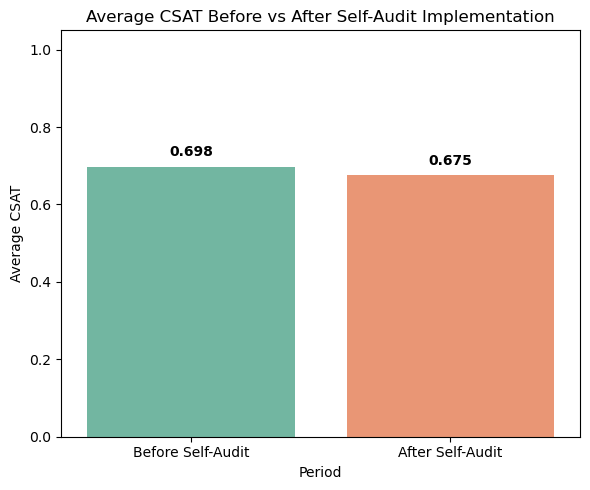

In [143]:

df_csat['post_audit'] = df_csat['response_date'] >= pd.Timestamp('2024-03-08')


pre_csat = df_csat[df_csat['post_audit'] == False]['csat_count']
post_csat = df_csat[df_csat['post_audit'] == True]['csat_count']

pre_avg = pre_csat.mean()
post_avg = post_csat.mean()


t_stat, p_val = ttest_ind(pre_csat, post_csat, equal_var=False)


print(f"Promedio CSAT Antes de Marzo: {pre_avg:.3f}")
print(f"Promedio CSAT Después de Marzo: {post_avg:.3f}")
print(f"T-test p-value: {p_val:.4f}")


avg_df = pd.DataFrame({
    'Period': ['Before Self-Audit', 'After Self-Audit'],
    'Average CSAT': [pre_avg, post_avg]
})

plt.figure(figsize=(6, 5))
ax = sns.barplot(data=avg_df, x='Period', y='Average CSAT', palette='Set2')
sns.barplot(data=avg_df, x='Period', y='Average CSAT', palette='Set2')
plt.title('Average CSAT Before vs After Self-Audit Implementation')
plt.ylim(0, 1.05)

for i, row in avg_df.iterrows():
    ax.text(i, row['Average CSAT'] + 0.02, f"{row['Average CSAT']:.3f}", 
            color='black', ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()